In [ ]:
import pandas as pd

In [ ]:
rock_musics = 'https://raw.githubusercontent.com/nazareno/palavras-nas-letras/master/letras-ptbr-rock-grande.csv'
data = pd.read_csv(rock_musics)
data.sample(10)

,SName,Lyric,Artist,Songs,Popularity,Genre,Genres
3122,É de Lágrima,É de lágrima. Que faço o mar pra navegar. Vamo...,Los Hermanos,80,5.5,Rock,Rock Alternativo; Rock; MPB; Romântico; Indie;...
6032,Luz (New Roots Remix),"De onde que vem essa luz, vem de cima. De onde...",Strike,49,1.3,Rock,Pop/Punk; Rock; Pop/Rock; Rock Alternativo; Pu...
5660,Verdade/Mentira,Jure pela vida que você teve. E ponha em risco...,Rosa de Saron,134,8.2,Rock,Gospel/Religioso; Rock; Pop/Rock; Romântico; R...
7087,O Sonho é Popular,A pampa é pop. o país é pobre. é pobre a pampa...,Engenheiros do Hawaii,193,11.9,Rock,Pop/Rock; Rock; Pop; Rock Alternativo; MPB; Se...
6818,Sabotagem,Lari lari lari lari. Eu vou sabotar. Você vai ...,Cássia Eller,141,7.5,Rock,Rock; MPB; Pop/Rock; Pop; Romântico; Samba; Co...
3893,Hóstia,Os que sobravam encostados no balcão. ali perm...,O Rappa,97,10.2,Rock,Reggae; Rap; Rock; Pop/Rock; Black Music; Funk...
6666,Turnê do Chopp,REFRÃO. Vira vira vira é a turnê do chopp (x3)...,Velhas Virgens,137,2.4,Rock,Rock; Blues; Punk Rock; Hard Rock; Rock Altern...
52,Eu Sei do Que Ela Gosta,eu sei do que ela gosta. isso eu tenho. a falt...,Aliados,75,0.8,Rock,Rock; Pop/Rock; Rock Alternativo; Surf Music; ...
174,Guarda Essa Canção,Era só um outro tempo de encantos escondidos e...,Barão Vermelho,160,3.8,Rock,Rock; Pop/Rock; MPB; Romântico; Rock Alternati...
166,Embriague-se,Tudo acaba nisso é a única questão. Embriagar-...,Barão Vermelho,160,3.8,Rock,Rock; Pop/Rock; MPB; Romântico; Rock Alternati...


**Análise Exploratória**

In [ ]:
num_artists = len(data.groupby('Artist'))
print(f'Número total de músicas: {data.shape[0]}')
print(f'Número total de artistas: {num_artists}')

Número total de músicas: 7680
Número total de artistas: 85


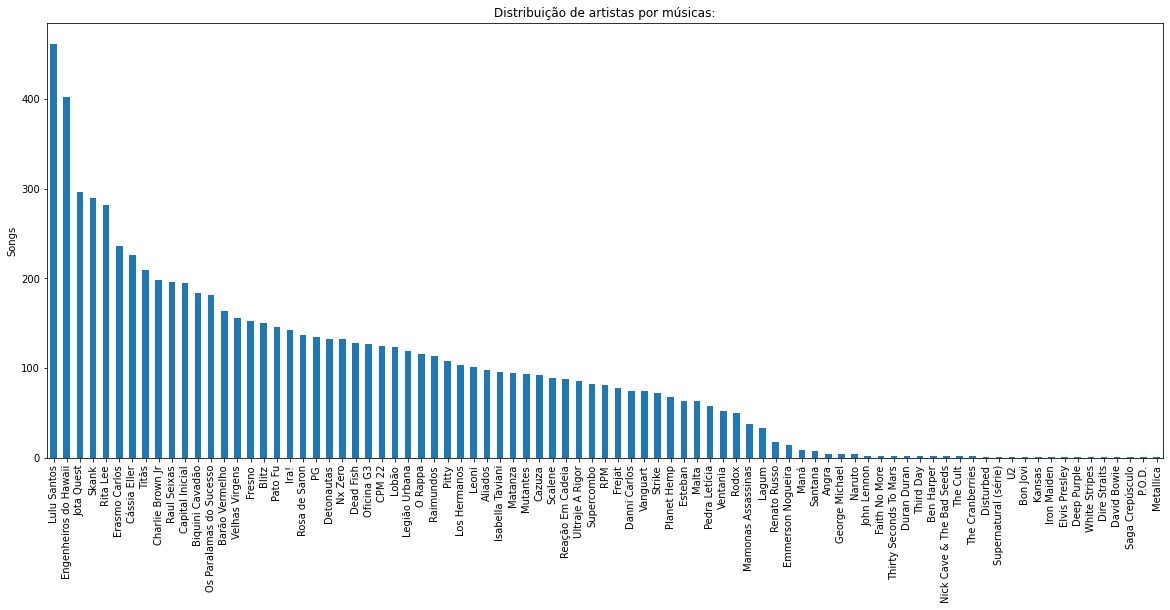

In [ ]:
data['Artist'].value_counts().sort_values(ascending=False).plot.bar(figsize=(20,8),title='Distribuição de artistas por músicas:',ylabel='Songs')

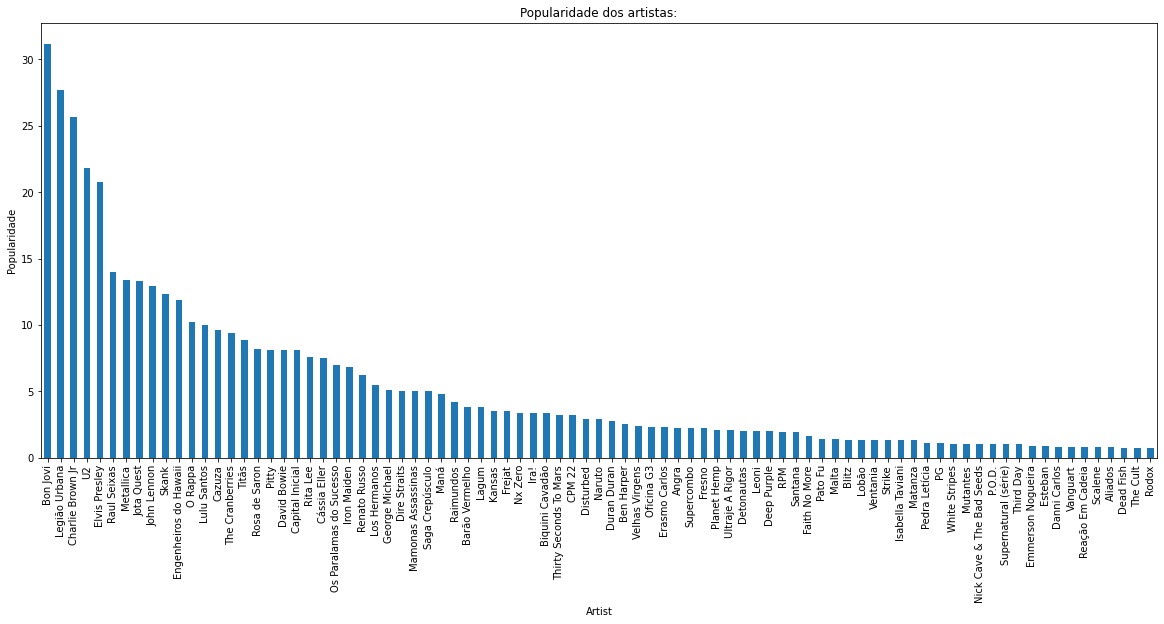

In [ ]:
data.groupby('Artist')['Popularity'].mean().sort_values(ascending=False).plot.bar(x='Artist',y='Songs',figsize=(20,8),title='Popularidade dos artistas:',ylabel='Popularidade')

**Preprocessamento do texto**

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
stop_words = set(stopwords.words('portuguese')) 

lyrics_rock = []
def preprocessing(lyric,sw=True):
  tokenizer = RegexpTokenizer('\w+')
  tokens = tokenizer.tokenize(lyric)
  if (sw):
    tokens = [word.lower() for word in tokens if word not in stop_words]

  lyrics_rock.append(' '.join(tokens).strip())

data['Lyric'].apply(preprocessing)
data = data.assign(LyricNorm=lyrics_rock)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Aplicando TFIDF no text preprocessado**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer(
    min_df = 10,
    max_df = 0.5,
    ngram_range = (2,2)
)

vec_text = tfv.fit_transform(lyrics_rock)
words = tfv.get_feature_names()

In [ ]:
print(f'Número de palavras (dimensões): {len(words)}')

Número de palavras (dimensões): 4334


**Escolhendo o melhor K**



*   Método do cotovelo



In [ ]:
from sklearn.cluster import KMeans

In [ ]:
qualidade = pd.DataFrame({'k': [], 'ssd': []})
for k in range(1,15):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(vec_text)
  qualidade = qualidade.append({'k': k, 'ssd': kmeans.inertia_}, ignore_index=True)

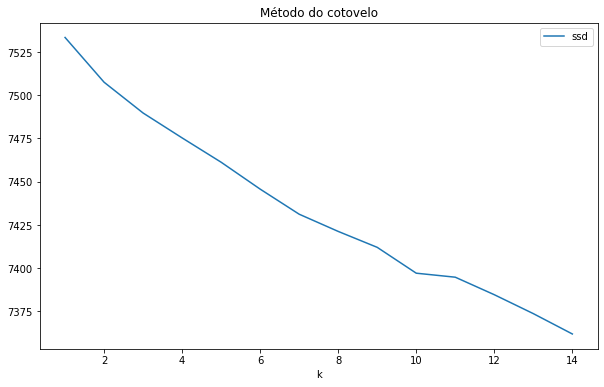

In [ ]:
qualidade.plot.line(x='k',y='ssd',figsize=(10,6),title='Método do cotovelo')

**Escolhendo K = 7**


In [ ]:
K = 7
kmeans = KMeans(n_clusters=K)
kmeans.fit(vec_text)
labels = kmeans.predict(vec_text)
aggruped = data.assign(Grupo=labels)

**As músicas foram mais associados ao grupo 2**

In [ ]:
aggruped['Grupo'].value_counts()

1    5746
5     429
3     406
6     315
4     272
2     256
0     256
Name: Grupo, dtype: int64

**Músicas do Grupo X**





In [ ]:
grupo = 3
aggruped[aggruped['Grupo'] == grupo][['SName','Artist','Lyric']].sample(5)

,SName,Artist,Lyric
6887,Oriente,Cássia Eller,"Se oriente, rapaz. Pela constelação. Do Cruzei..."
2309,Amor Impossível,Ira!,É possível falar. De um amor impossível. Sem p...
1931,Novo Sentido,Erasmo Carlos,"Deixe estar, meu amor. Que eu não preciso de l..."
1666,Infinita Highway (versão Acústico Mtv),Engenheiros do Hawaii,Você me faz correr demais os riscos desta high...
4714,Stab,Planet Hemp,Eu me apresento em alto e bom som para que tod...


**Artistas mais presentes em cada Grupo**


In [ ]:
for grupo in range(K):
  print(f'===== Grupo: {grupo}')
  print(aggruped[aggruped['Grupo'] == grupo]['Artist'].value_counts()[:5])

===== Grupo: 0
Lulu Santos              38
Engenheiros do Hawaii    28
Jota Quest               16
Velhas Virgens           13
Blitz                    10
Name: Artist, dtype: int64
===== Grupo: 1
Lulu Santos              348
Engenheiros do Hawaii    310
Rita Lee                 234
Skank                    212
Jota Quest               198
Name: Artist, dtype: int64
===== Grupo: 2
Engenheiros do Hawaii    22
Planet Hemp              17
Lulu Santos              12
Blitz                    12
Skank                    12
Name: Artist, dtype: int64
===== Grupo: 3
Engenheiros do Hawaii    32
Cássia Eller             24
Skank                    24
Jota Quest               24
Lulu Santos              18
Name: Artist, dtype: int64
===== Grupo: 4
Cássia Eller       16
Rita Lee           14
Capital Inicial    13
Jota Quest         12
Pitty              11
Name: Artist, dtype: int64
===== Grupo: 5
Charlie Brown Jr    28
Los Hermanos        23
Malta               20
Fresno              19
Erasmo C

**Visualizando as ínumeras dimensões em um plano 2D**

In [ ]:
from sklearn.manifold import TSNE

letras_embedded = TSNE(n_components=2, verbose=1).fit_transform(vec_text)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7680 samples in 0.001s...
[t-SNE] Computed neighbors for 7680 samples in 1.326s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7680
[t-SNE] Computed conditional probabilities for sample 2000 / 7680
[t-SNE] Computed conditional probabilities for sample 3000 / 7680
[t-SNE] Computed conditional probabilities for sample 4000 / 7680
[t-SNE] Computed conditional probabilities for sample 5000 / 7680
[t-SNE] Computed conditional probabilities for sample 6000 / 7680
[t-SNE] Computed conditional probabilities for sample 7000 / 7680
[t-SNE] Computed conditional probabilities for sample 7680 / 7680
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 115.621902
[t-SNE] KL divergence after 1000 iterations: 2.964367


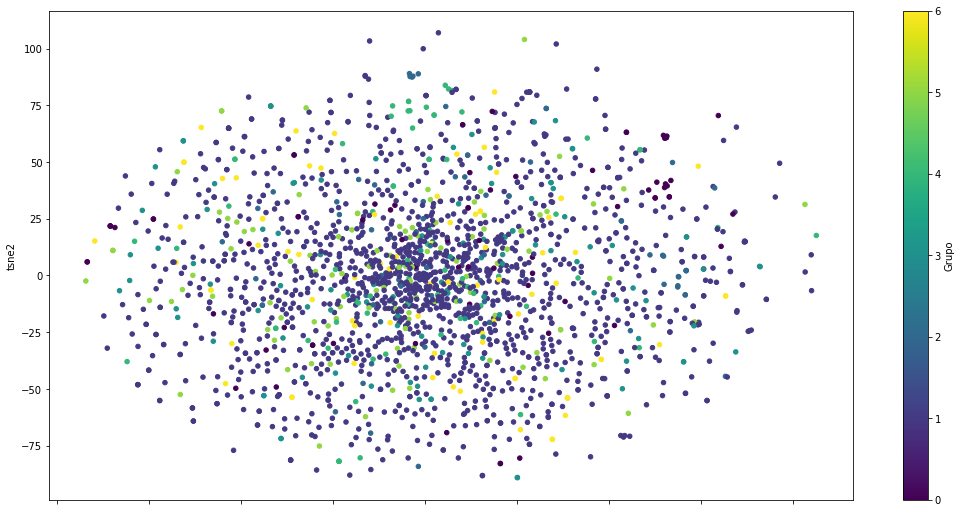

In [ ]:
letras_ag = aggruped.assign(tsne1 = letras_embedded[:,0], tsne2 = letras_embedded[:,1])
letras_ag.sample(2000).plot.scatter(x='tsne1',y='tsne2',c='Grupo',colormap='viridis',figsize=(18,9))

**Visualizando palavas mais frequentes com uma WordCloud**

===== Grupo: 1 =====


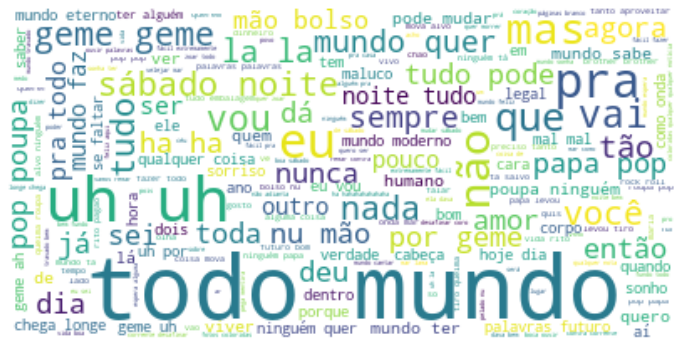

===== Grupo: 2 =====


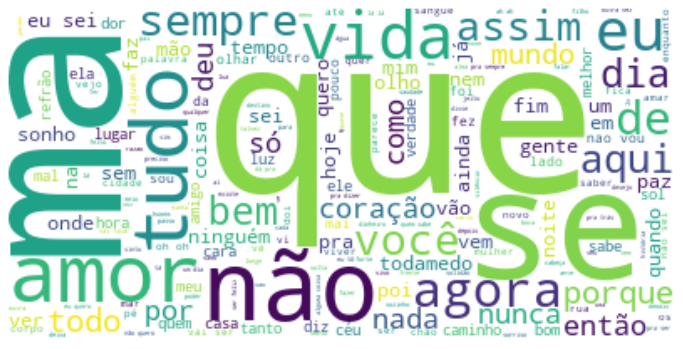

===== Grupo: 3 =====


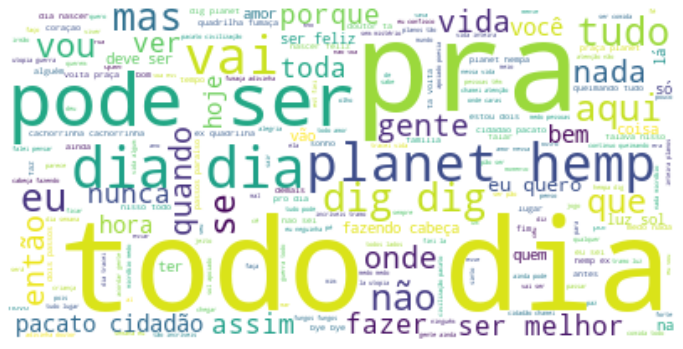

===== Grupo: 4 =====


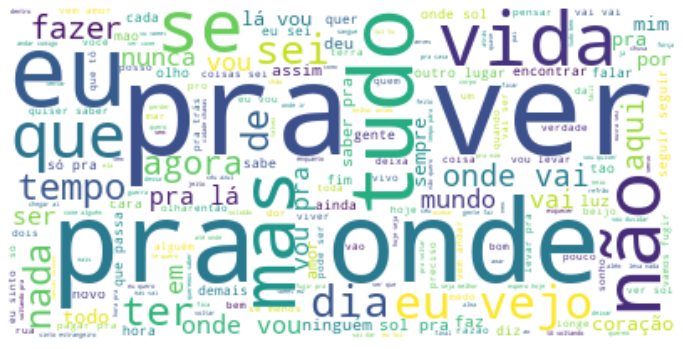

===== Grupo: 5 =====


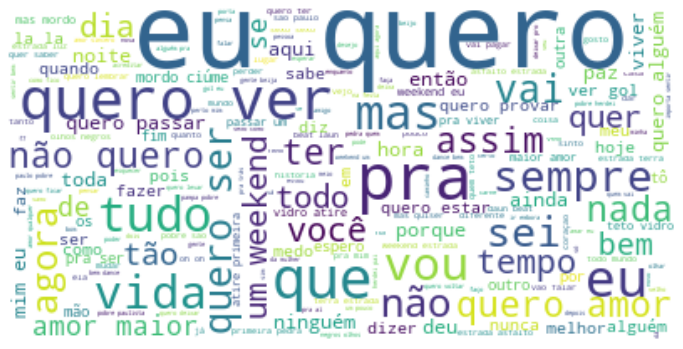

===== Grupo: 6 =====


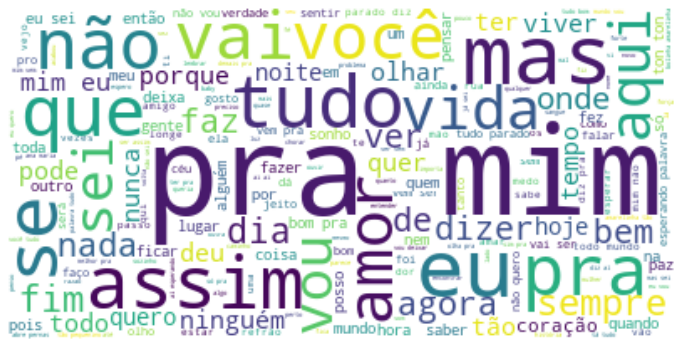

===== Grupo: 7 =====


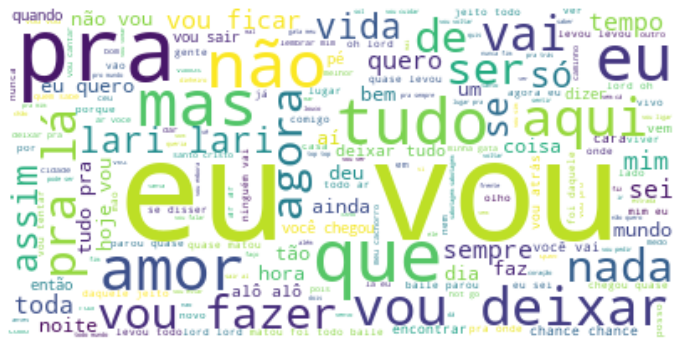

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

for i in range(7):
  print(f'===== Grupo: {i+1} =====')
  wc = WordCloud(background_color="white").generate(''.join(aggruped[aggruped['Grupo'] == i]['LyricNorm'].values))
  plt.figure(figsize=(12,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [ ]:
sample = aggruped[aggruped['Grupo'] == 6].sample(1)
music_name = sample['SName'].values
artist_name = sample['Artist'].values
print(f'Nome da Música: {music_name}')
print(f'Nome do Artista: {artist_name}\n')
''.join(map(str,sample['Lyric'].iloc[0]))

Nome da Música: ['Pra Sempre Essa Noite']
Nome do Artista: ['Lobão']



"Através do ceú. Desse céu azul. Vou caminhando pelas ruas do Leblon. Eu não vou parar. Eu vou continuar. Até chegar lá em Copacabana. Agora o céu mudou. Entre arranha-céus. as luzes vao piscando entre as nuvens. Passa a multidão, cai o pôr-do-sol. Ainda não sei por onde você anda. É noite derrepente. E o vento assobia. A noite é morna. Chove e ninguém nota. As cidades e os corpos. A cidade e as almas. E entre as ondas. Eu escuto o teu nome. Nem tudo é deserto. Mas o vazio lento. É o mesmo em que tudo se transforma. Em ruas sem fim. Feitos sem você. Em praias que já não te banham. Uma ilha longe. Voa no horizonte. Flutuando meio fora d'água. Você ainda esta aí. Ainda quer me ver. Ainda quer me amar pra sempre essa noite?. Pra sempre essa noite. E a beleza intensa. em plena Ipanema. holoforte crivam um Vidigal de luz. Talvez não seja assim. em outro lugar. Uma ilha flutuando em pleno ar. Eu quero você apaixonada. Delirando de felicidade. E que o nosso amor, seja como for. que nosso amor

In [ ]:
a = aggruped[aggruped['Artist'] == 'PG']
a[aggruped[aggruped['Artist'] == 'PG']['Lyric'].apply(lambda x : 'Amando a Jesus, o Salvador.' in x)]

,SName,Lyric,Artist,Songs,Popularity,Genre,Genres,LyricNorm,Grupo
4485,A Arte do Saber,"Eu gosto de ensinar, de ler e escrever. De ver...",PG,111,1.1,Rock,Rock; Gospel/Religioso; Pop/Rock; Funk; Clássi...,eu gosto ensinar ler escrever de ver criançada...,1
4494,A Arte do Saber,"Eu gosto de ensinar, de ler e escrever. De ver...",PG,111,1.1,Rock,Rock; Gospel/Religioso; Pop/Rock; Funk; Clássi...,eu gosto ensinar ler escrever de ver criançada...,1


### Análise dos grupos



*   Grupo 1: Amor 
  * Amando a Jesus, o Salvador. *PG - A Arte do Saber*
  * De um tom sobrevivente. Que ilumine a cor do nosso amor. *Erasmo Carlos - 50 Tons de Cor*
*   Grupo 2: Decepções Amorosas 
  * Quer saber? Já foi. Vou cuidar de mim. *Jota Quest - Já foi*
  * Seu rosto ficou na minha cabeça. Quando quebrei nosso mural. Sofrer era tudo o que eu queria. *Supercombo - Vou Assombrar Seus Amigos E Parentes*
*   Grupo 3: Uso de metáforas e Figuras de linguagem 
  * Eu já falei sobre disco voador. E da metamorfose que eu sou. *Raul Seixas - Cantar*
  * qual é a tua?. Que bicho te mordeu aí na lua?. Eu vou pro mundo da lua. *Lulu Santos - Astronauta*
*   Grupo 4: Não identificado 
  * Vou deixar a vida me levar. Pra onde ela quiser. *Skank - Vou Deixar*
  * Quando eu abro a janela, quando eu abro o jornal. *Engenheiros do Hawaii - Beijos pra Torcida*
*   Grupo 5: Revolucionário 
  * Se essa guerra acabar. Me diga com quem você vai lutar?. *Esteban - O Que Não Vem*
  * Andava pela rua. Toda noite, todo dia. Ouvindo notícias. Dos heróis que voltaram. *Lobão - Ronaldo foi pra Guerra*
*   Grupo 6: Declarações de amor 
  * Antes que eu me esqueça da minha cabeça. Escreve teu nome nesse papel. *Vanguart - Antes Que Eu Me Esqueça*
  * Vê que meu sorriso. É verdadeiro. Meu coração está desperto. *Renato Russo - Celeste*
*   Grupo 7: Não identificado
  * São 7 horas da manhã. Vejo Cristo da janela. O sol já apagou sua luz. *Cazuza - Um Trem Para as Estrelas*
  * Em praias que já não te banham. Uma ilha longe. Voa no horizonte.  *Lobão - Pra Sempre Essa Noite*

